# Credit Card Anomaly Detection 

### Summary

Fraudulent credit card activity costs the financial industry millions of dollars anually. Anomaly detection is key to recognizing and preventing fraudulent credit card activity.

### Background

This dataset has already been feature engineered using Principal Component Analysis (PCA). Each column has been masked and normalized for governance purposes. The Amount and Time features have been left unmasked. The "Class" featured is the response variable, with a value of 1 = fraud, and 0 otherwise.

### Objective

The purpose of this script is to anaylze the creditcard.csv data set, and then train and run several ML models. The algorithms used will be Isolation Forest, Local Outlier Factor, Support Vector Machine, Logistic Regression, Linear Discriminant Analysis, Quadratic Discriminant Analysis, and K-Nearest Neighbors.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
warnings.filterwarnings('ignore')

#### Exploratory Data Analysis

In [2]:
#reading and observing dataset
df = pd.read_csv('creditcard.csv', sep=',')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#summarizing dataset properties
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
#checking for null values
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

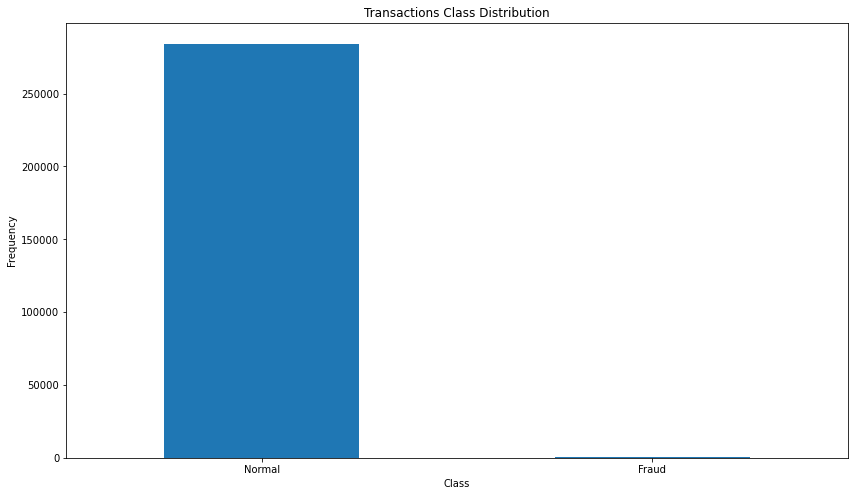

In [5]:
#identifying unique classes, counting instances
#plotting bar chart of results
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transactions Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
#classifying instances of fraud and normal
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

In [7]:
#observing dimensionality
print(fraud.shape, normal.shape)

(492, 31) (284315, 31)


In [8]:
#observing the distribution of purchase amounts for fraudulent transactions
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
#observing the distribution of purchase amounts for normal transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

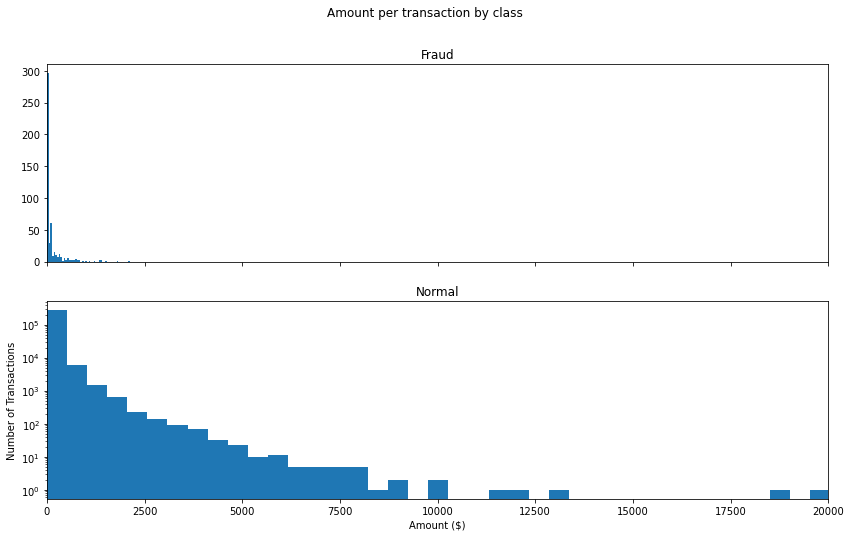

In [10]:
#observing count of transactions grouped by amount
f, (axis1, axis2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
axis1.hist(fraud.Amount, bins = bins)
axis1.set_title('Fraud')
axis2.hist(normal.Amount, bins = bins)
axis2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim(0, 20000)
plt.yscale('log')
plt.show()

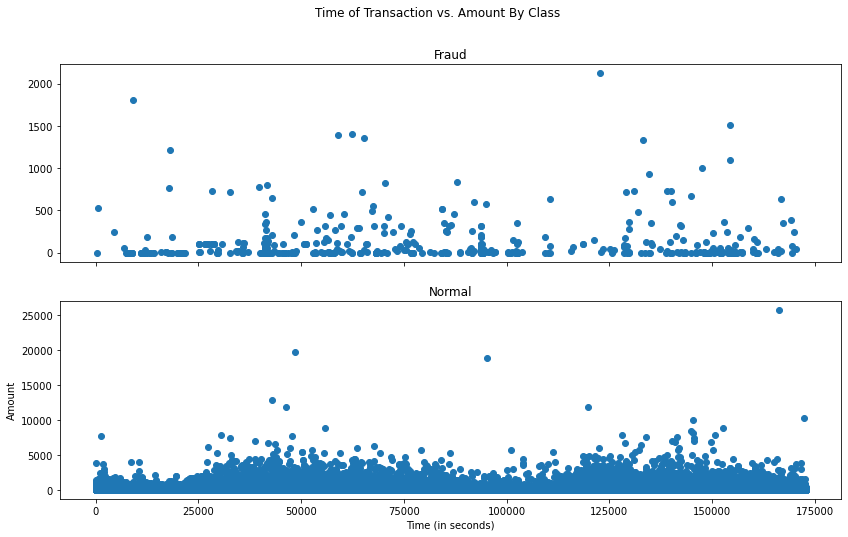

In [11]:
f, (axis1, axis2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of Transaction vs. Amount By Class')
axis1.scatter(fraud.Time, fraud.Amount)
axis1.set_title('Fraud')
axis2.scatter(normal.Time, normal.Amount)
axis2.set_title('Normal')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

In [12]:
#creating sample of the data
df1 = df.sample(frac = 0.15, random_state=1)
df1.shape

(42721, 31)

In [13]:
df.shape

(284807, 31)

In [14]:
#Counting fraudulent and normal transactions, determining fraud rate
fraud = df1[df1['Class']==1]
valid = df1[df1['Class']==0]
outlier_fraction = len(fraud)/float(len(valid))

In [15]:
print(outlier_fraction)
print("fraud cases : {}".format(len(fraud)))
print("valid cases : {}".format(len(valid)))

0.0016177435993622808
fraud cases : 69
valid cases : 42652


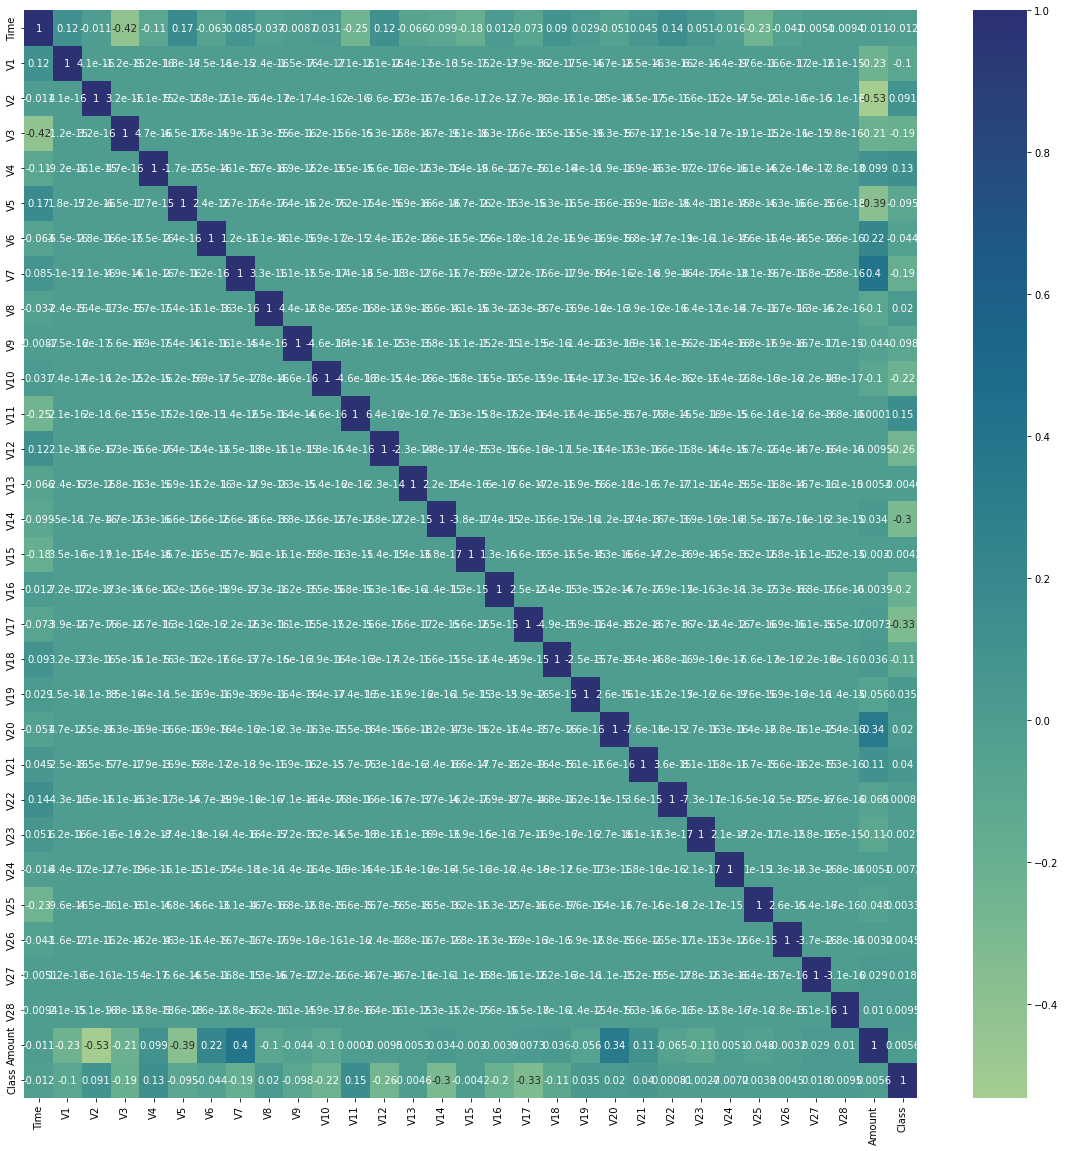

In [16]:
#Observing correlations
corrmat = df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(), cmap="crest", annot=True)

In [17]:
#create independent and dependent features
columns = df1.columns.tolist()

#remove unwanted columns
columns = [c for c in columns if c not in ["Class"]]
target = "Class"

#define random state
state = np.random.RandomState(55)
X = df1[columns]
y = df1[target]
X_Outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

print(X.shape)
print(y.shape)

(42721, 30)
(42721,)


## Machine Learning / Prediction Model(s)

#### Isolation Forest:

Isolation Forest is an unsupervised machine learning algorithm that is used for anomaly detection. The algorithm creates isolation trees, which are binary trees that split the data randomly, with the aim of isolating anomalies in the data. Anomalies are typically found in regions of the data with fewer points, and hence, fewer splits are required to isolate them. The algorithm works by counting the number of splits required to isolate a point, and the fewer the splits required, the more likely the point is to be an anomaly.

#### Local Outlier Factor:

Local Outlier Factor (LOF) is another unsupervised machine learning algorithm used for anomaly detection. The algorithm computes a score for each point in the data, based on the density of its local neighborhood. Points that have a much lower density than their neighbors are considered to be anomalies. The algorithm works by computing the ratio of the average distance of a point to its k nearest neighbors, and the average distance of the k nearest neighbors to each other. The resulting score is a measure of the degree to which a point is an outlier.

#### Support Vector Machine:

Support Vector Machine (SVM) is a supervised machine learning algorithm that is used for classification and regression. The algorithm works by finding a hyperplane that separates the data into two classes, in such a way that the margin between the hyperplane and the closest points from each class is maximized. The algorithm can be used for linear and non-linear classification, and it is particularly useful for datasets with high dimensionality.

#### Logistic Regression:

Logistic Regression is a supervised machine learning algorithm that is used for binary classification. The algorithm works by fitting a logistic function to the data, which models the probability of the target variable taking on one of two possible values. The logistic function is defined as the inverse of the logit function, which transforms the output of a linear function into a probability value between 0 and 1. The algorithm can be extended to handle multi-class classification by using a one-vs-all approach.

#### Linear Discriminant Analysis

Linear Discriminant Analysis (LDA) is a statistical method used for classification problems where the goal is to assign an observation to one of two or more classes based on a set of predictor variables or features. LDA assumes that the predictor variables are normally distributed and that the covariance matrices of each class are equal. It seeks to find a linear combination of the predictor variables that maximally separates the classes by minimizing the within-class variance and maximizing the between-class variance. The resulting linear discriminant function can be used to predict the class of new observations. LDA is widely used in various fields such as finance, marketing, and biomedical research.

#### Quadratic Discriminant Analysis


Quadratic Discriminant Analysis (QDA) is a statistical method used for classification problems where the goal is to assign an observation to one of two or more classes based on a set of predictor variables or features. Unlike Linear Discriminant Analysis (LDA), QDA does not assume that the covariance matrices of each class are equal. Instead, QDA estimates a separate covariance matrix for each class. QDA seeks to find a quadratic discriminant function that maximally separates the classes by minimizing the within-class variance and maximizing the between-class variance. The resulting quadratic discriminant function can be used to predict the class of new observations. QDA is useful when the data has non-linear relationships and may be able to better capture the complex relationship between features and the target variable compared to LDA. However, QDA requires estimating more parameters than LDA and may be prone to overfitting when the number of features is large relative to the number of samples.

#### K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN), is a statistical method used for classification problems that estimates how likely a data point is to be a member of one group or the other depending on what group the data points nearest to it are in.

In [18]:
#initializing classifiers
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=75, max_samples=len(X),
                                        contamination=outlier_fraction, random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=7, algorithm='auto', 
                                               leaf_size=650, metric='minkowski'),
    "Support Vector Machine": OneClassSVM(kernel='linear', gamma='auto', nu=0.0000001, max_iter=-1),    
    "Logistic Regression": LogisticRegression(penalty='l2', C=5.0, fit_intercept=True, 
                                           intercept_scaling=1, max_iter=1000, multi_class='auto'),
    "Linear Discriminant Analysis": LDA(solver='lsqr', shrinkage='auto'),
    "Quadratic Discriminant Analysis": QDA(tol=0.0005),
    "K-Nearest Neighbors": KNN(n_neighbors=7, weights='distance')
}

In [19]:
type(classifiers)

dict

In [20]:
n_outliers = len(fraud)

#measuring runtime
start_time = time.time()

#predictions
for i, (clf_name, clf) in enumerate(classifiers.items()):
    if clf_name == "Isolation Forest":
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    elif clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    elif clf_name == "Logistic Regression":
        clf.fit(X, y)
        y_pred = clf.predict(X)
    elif clf_name == "Linear Discriminant Analysis":
        clf.fit(X, y)
        y_pred = clf.predict(X)
    elif clf_name == "Quadratic Discriminant Analysis":
        clf.fit(X, y)
        y_pred = clf.predict(X)
    else:
        clf.fit(X, y)
        y_pred = clf.predict(X)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    print("{}: {}".format(clf_name, n_errors))
    print("Accuracy Score: ")
    print(round((accuracy_score(y, y_pred)),5))
    print("Classification Report: ")
    print(classification_report(y, y_pred))

#measuring runtime
end_time = time.time()
run_time = end_time - start_time
print('Execution time:', round(run_time,2), 'seconds...')

Isolation Forest: 105
Accuracy Score: 
0.99754
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42652
           1       0.24      0.25      0.24        69

    accuracy                           1.00     42721
   macro avg       0.62      0.62      0.62     42721
weighted avg       1.00      1.00      1.00     42721

Local Outlier Factor: 2376
Accuracy Score: 
0.94438
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     42652
           1       0.01      0.17      0.01        69

    accuracy                           0.94     42721
   macro avg       0.50      0.56      0.49     42721
weighted avg       1.00      0.94      0.97     42721

Support Vector Machine: 70
Accuracy Score: 
0.99836
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42652
           1  

#### Results

Isolation Forest returned an accuracy score of 99.75%, reporting 105 outliers and an F1 (precision) score of 1.
Local Outlier Factor returned an accuracy score of 94.44%, reporting 2376 outliers and an F1 (precision) score of .97.
Support Vector Machine (SVM) returned an accuracy score of 99.84%, reporting 70 outliers and an F1 (precision) score of 1.
Logistic Regression returned an accuracy score of 99.84%, reporting 69 outliers and an F1 (precision) score of 1.
Linear Discriminant Analysis (LDA) returned an accuracy score of 99.84%, reporting 69 outliers and an F1 (precision) score of 1.
Quadratic Discriminant Analysis (QDA) returned an accuracy score of 99.84%, reporting 69 outliers and an F1 (precision) score of 1.
K-Nearest Neighbors (KNN) returned an accuracy score of 99.84%, reporting 69 outliers and an F1 (precision) score of 1.
